<a href="https://colab.research.google.com/github/cromcruach52/Activity-1-LoginPage-React/blob/main/Model_Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch-lr-finder

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install split-folders

In [1]:
import os
import pandas as pd
import random
import seaborn as sns
import cv2
import torch
import torchvision
import shutil

from PIL import Image
from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam

import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import splitfolders
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# I. Data Preparation Phase

In [2]:
leaf_path = "/content/drive/My Drive/Samples/Leaf_Samples/"
non_leaf_path = "/content/drive/My Drive/Samples/NonLeaf_Samples/"
output_dir = "/content/drive/My Drive/Samples/splitted_data"

In [3]:
def pad_image(image):
    width, height = image.size
    max_dim = max(width, height)
    background_color = tuple(np.random.randint(0, 256, size=3))
    background = Image.new('RGB', (max_dim, max_dim), background_color)
    pos = ((max_dim - width) // 2, (max_dim - height) // 2)
    background.paste(image, pos)
    return background

In [4]:
def sobel_edge_detection(image):
    image = np.array(image)
    channels = []
    for i in range(3):
        gray = image[:, :, i]
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = np.uint8(sobel)
        channels.append(sobel)
    sobel = np.stack(channels, axis=-1)
    return Image.fromarray(sobel)

class SobelEdgeDetection(object):
    def __call__(self, img):
        return sobel_edge_detection(img)

In [5]:
data_transforms = transforms.Compose([
    transforms.Lambda(pad_image),
    transforms.Resize(size=(224, 224)),
    SobelEdgeDetection(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
class LeafDataset(Dataset):
    def __init__(self, leaf_dir, non_leaf_dir, transform=None, non_leaf_limit=300):
        self.leaf_dir = leaf_dir
        self.non_leaf_dir = non_leaf_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load leaf images
        for class_dir in os.listdir(leaf_dir):
            class_path = os.path.join(leaf_dir, class_dir)
            if os.path.isdir(class_path):
                for img_path in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_path))
                    self.labels.append(0)  # Leaf class label

        # Load limited non-leaf images
        non_leaf_images = []
        for img_path in os.listdir(non_leaf_dir):
            non_leaf_images.append(os.path.join(non_leaf_dir, img_path))

        non_leaf_images = random.sample(non_leaf_images, non_leaf_limit)
        for img_path in non_leaf_images:
            self.image_paths.append(img_path)
            self.labels.append(1)  # Non-leaf class label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [7]:
def visualize_images_before_after(dataset, transform, num_images=10):
    num_rows = (num_images + 1) // 2
    fig, ax = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

    for i in range(num_images):
        row = i // 2
        col = (i % 2) * 2

        sample_index = random.randint(0, len(dataset) - 1)
        img_path, label = dataset.imgs[sample_index]

        img = Image.open(img_path).convert('RGB')
        ax[row, col].imshow(img)
        ax[row, col].title.set_text(f"Original Image - {'Leaf' if label == 0 else 'Non-Leaf'}")

        img_transformed = transform(img)
        img_transformed = img_transformed.permute(1, 2, 0).numpy()
        img_transformed = (img_transformed * 0.229) + 0.485
        ax[row, col + 1].imshow(img_transformed)
        ax[row, col + 1].title.set_text(f"Processed Image - {'Leaf' if label == 0 else 'Non-Leaf'}")

    plt.tight_layout()
    plt.show()

In [15]:
def combine_and_split_dataset(leaf_dir, non_leaf_dir, output_dir, test_ratio=(10, 20)):
    os.makedirs(output_dir, exist_ok=True)

    leaf_output_dir = os.path.join(output_dir, 'Leaf')
    non_leaf_output_dir = os.path.join(output_dir, 'NonLeaf')

    os.makedirs(leaf_output_dir, exist_ok=True)
    os.makedirs(non_leaf_output_dir, exist_ok=True)

    # Copy all leaf images
    for root, _, files in os.walk(leaf_dir):
        for file in files:
            shutil.copy(os.path.join(root, file), os.path.join(leaf_output_dir, file))

    # Correctly copy only the first 300 non-leaf images
    non_leaf_files = os.listdir(non_leaf_dir)[:300]  # Select first 300 files
    for file in non_leaf_files:
        shutil.copy(os.path.join(non_leaf_dir, file), os.path.join(non_leaf_output_dir, file))

    # Split the dataset
    splitfolders.ratio(output_dir, output=output_dir, seed=42, ratio=(.75, .15, .10))

combine_and_split_dataset(leaf_path, non_leaf_path, output_dir)

Copying files: 374 files [00:08, 42.62 files/s]


In [16]:
# Load datasets
train = datasets.ImageFolder(root=os.path.join(output_dir, "train"), transform=data_transforms)
val = datasets.ImageFolder(root=os.path.join(output_dir, "val"), transform=data_transforms)
test = datasets.ImageFolder(root=os.path.join(output_dir, "test"), transform=data_transforms)

In [33]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True,
                             pin_memory=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True,
                             pin_memory=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False,
                             pin_memory=True)

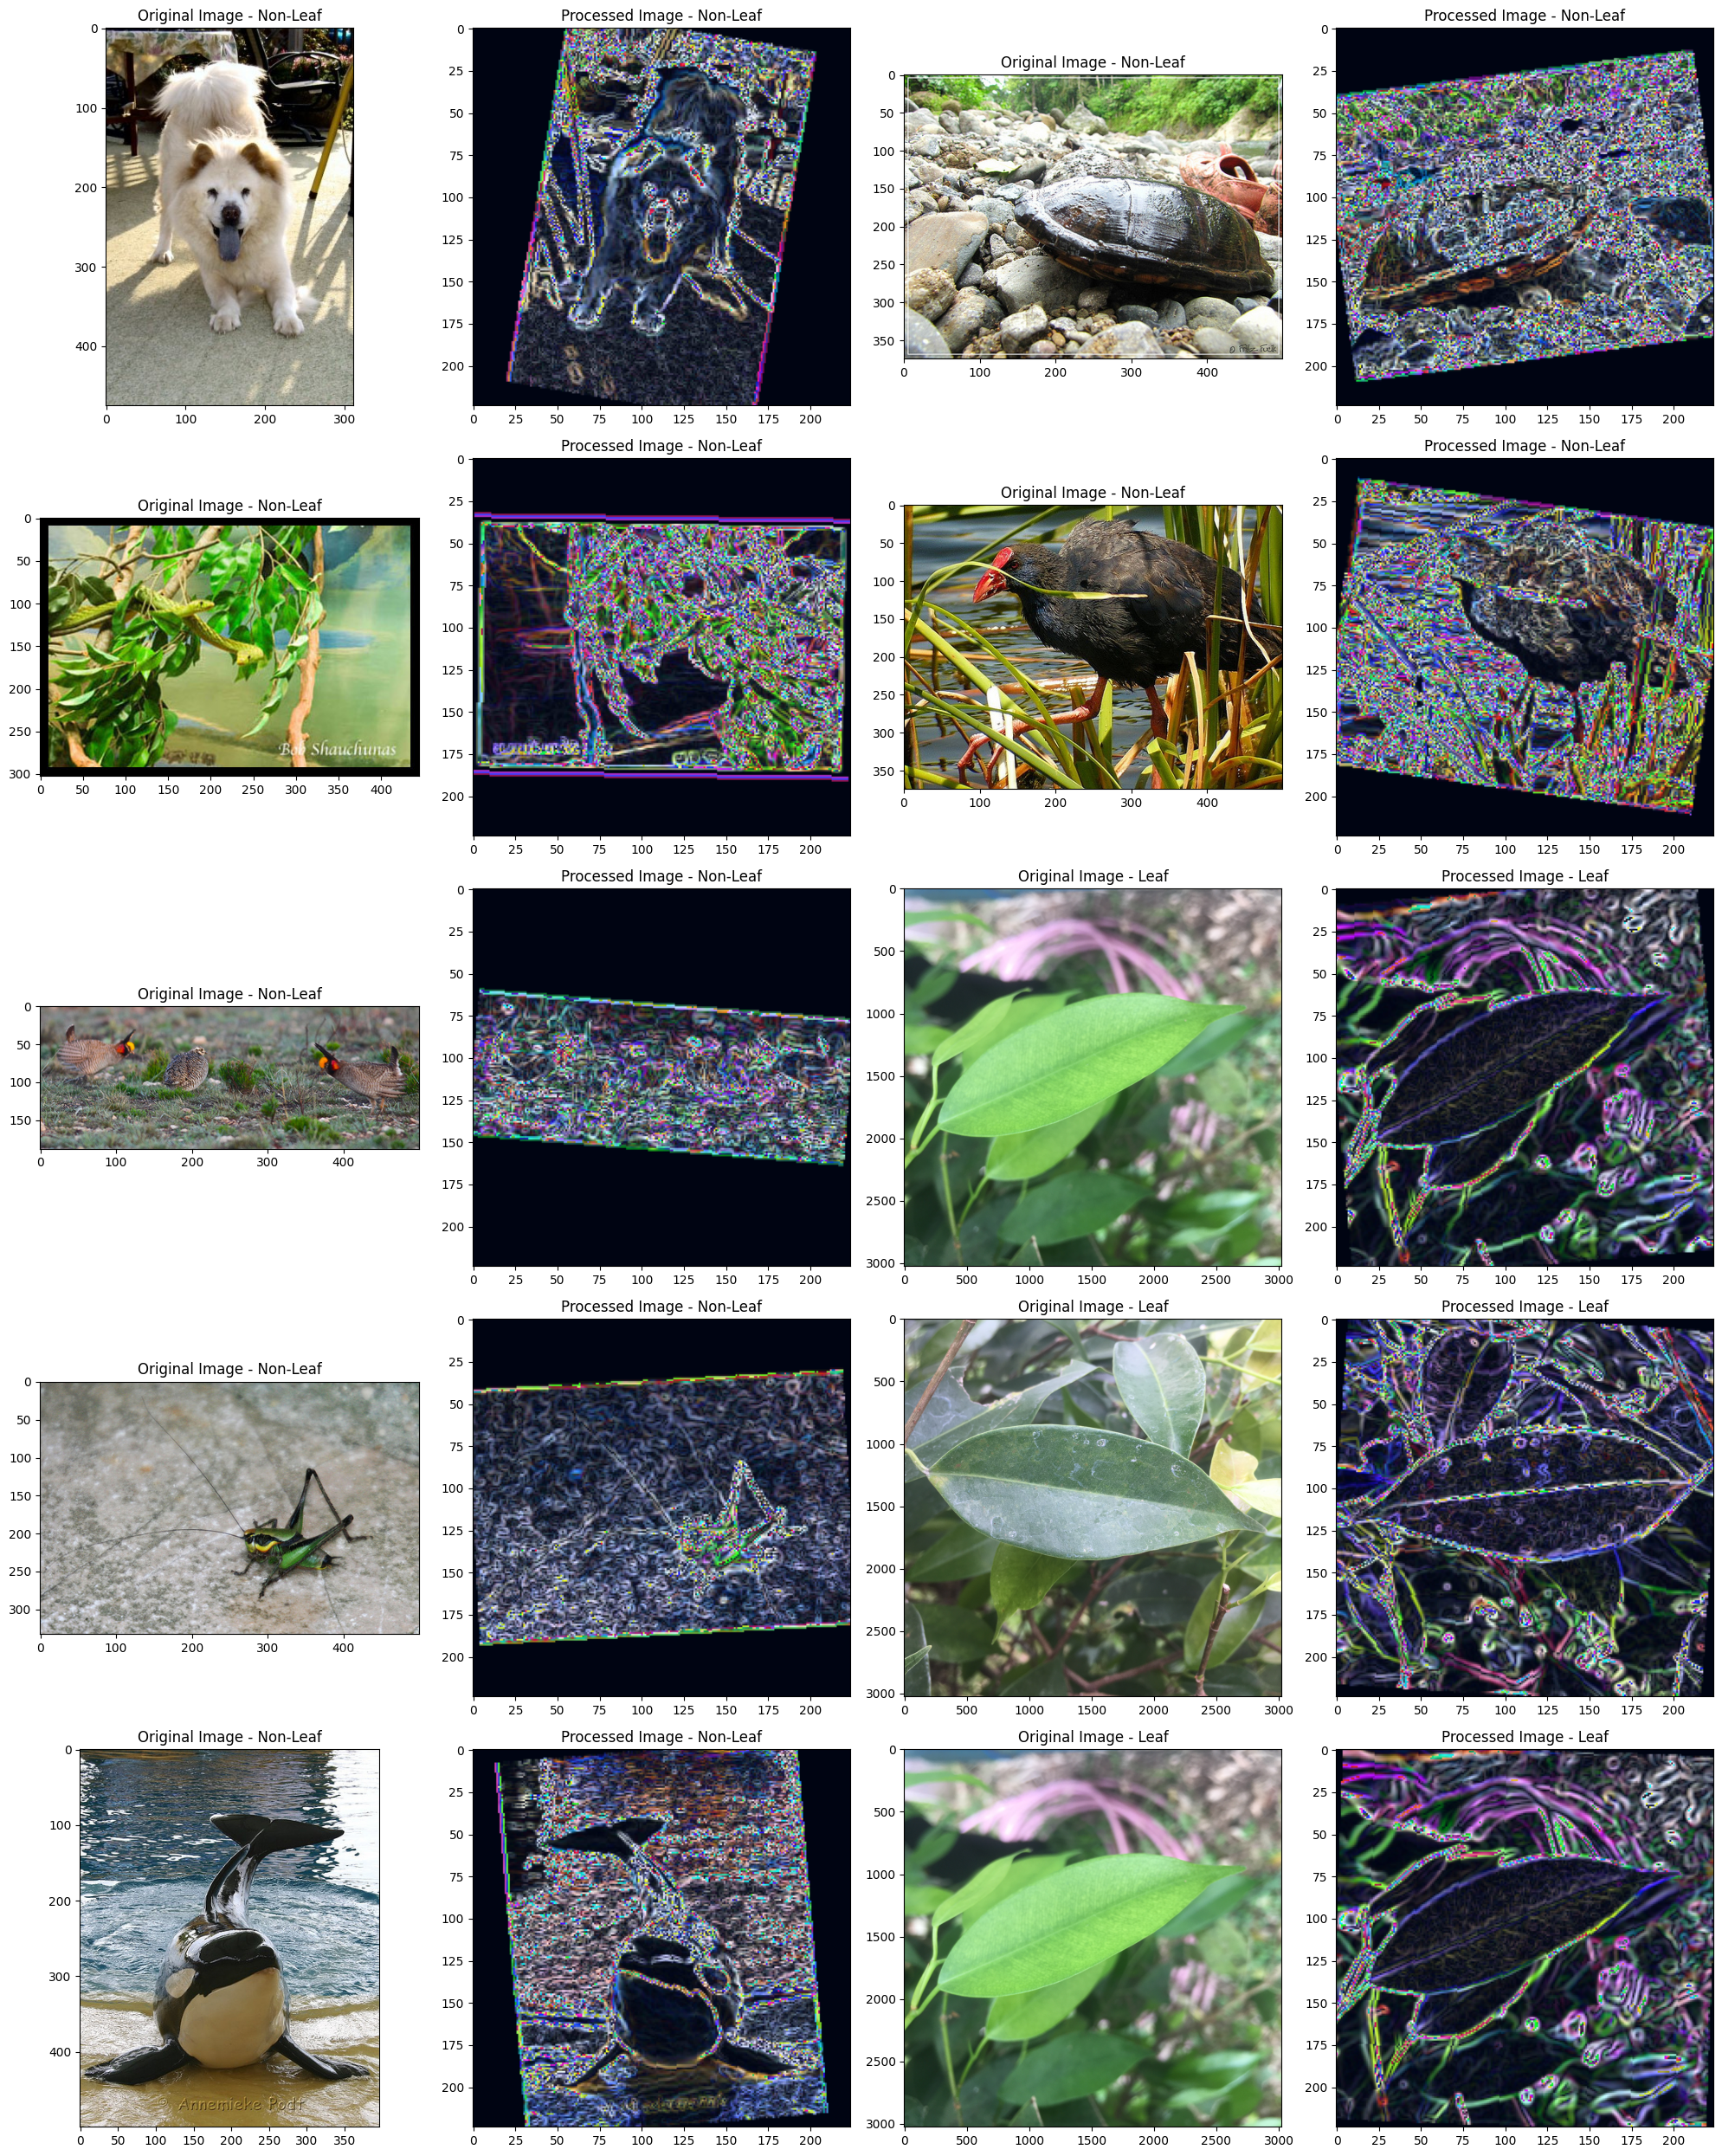

In [17]:
visualize_images_before_after(train, data_transforms, num_images=10)

In [18]:
class_to_idx = train.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Dataset Labels:\n", class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series([class_to_idx[dataset.classes[target]] for target in dataset.targets]).value_counts()
    print(f"Images per Class in {name}:")
    for idx in sorted(images_per_class.index):
        print(f"{idx}    {idx_to_class[idx]}: {images_per_class[idx]}")
    print()

Dataset Labels:
 {'Leaf': 0, 'NonLeaf': 1} 

Images per Class in TRAIN:
0    Leaf: 55
1    NonLeaf: 225

Images per Class in VALIDATION:
0    Leaf: 11
1    NonLeaf: 45

Images per Class in TEST:
0    Leaf: 8
1    NonLeaf: 30



# II. Model Setup Phase


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [20]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=models.ResNet50_Weights.DEFAULT)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [21]:
for param in resnet.parameters():
    param.requires_grad = False

In [22]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

In [23]:
model = resnet.to(device)

# III. Loss Function and Optimizer Setup

In [27]:
class_labels = ['Leaf', 'NonLeaf']

total_samples = len(train)

samples_per_class = {
    'Leaf': sum([len(files) for r, d, files in os.walk(os.path.join(output_dir, 'train', 'Leaf'))]) +
            sum([len(files) for r, d, files in os.walk(os.path.join(output_dir, 'val', 'Leaf'))]) +
            sum([len(files) for r, d, files in os.walk(os.path.join(output_dir, 'test', 'Leaf'))]),
    'NonLeaf': sum([len(files) for r, d, files in os.walk(os.path.join(output_dir, 'train', 'NonLeaf'))]) +
               sum([len(files) for r, d, files in os.walk(os.path.join(output_dir, 'val', 'NonLeaf'))]) +
               sum([len(files) for r, d, files in os.walk(os.path.join(output_dir, 'test', 'NonLeaf'))])
}

print("Total samples:", total_samples)
print("Samples per class:", samples_per_class)


Total samples: 280
Samples per class: {'Leaf': 74, 'NonLeaf': 300}


In [29]:
# Calculate initial class weights based on the total samples and samples per class
initial_class_weights = [total_samples / samples_per_class[class_label] for class_label in class_labels]

# Apply log scaling to the initial class weights
class_weights = [np.log1p(weight) for weight in initial_class_weights]

print("Initial class weights:", initial_class_weights)
print("Log-scaled class weights:", class_weights)


Initial class weights: [3.7837837837837838, 0.9333333333333333]
Log-scaled class weights: [1.5652318199296047, 0.659245628884264]


In [42]:
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)  # Ensure weights are float32 type
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=64, patience=5, checkpoint_path='model_checkpoint.pth'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False

    for epoch in range(num_epochs):
        if early_stop:
            print('Breaking out of epoch loop due to early stopping.')
            break

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
              inputs = inputs.to(device).float()
              labels = labels.to(device).long()  # Ensure labels are long type

              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  # Convert outputs to float32 explicitly
                  outputs = outputs.float()

                  # No need to convert labels to float32
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

                  _, preds = torch.max(outputs, 1)
                  running_corrects += torch.sum(preds == labels.data)
                  running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True
                        break

        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
            'best_loss': best_loss,
            'best_acc': best_acc,
        }, checkpoint_path)

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=64, patience=5, checkpoint_path='model_checkpoint.pth')

torch.save(model.state_dict(), 'final_model.pth')
print("Training finished...\n")


Epoch 1/64
----------
Learning Rate: 0.001
train Loss: 0.5170 Acc: 0.8143
val Loss: 0.3650 Acc: 0.9464
Epoch 2/64
----------
Learning Rate: 0.001
train Loss: 0.3055 Acc: 0.9429
val Loss: 0.2038 Acc: 0.9821
Epoch 3/64
----------
Learning Rate: 0.001
train Loss: 0.1969 Acc: 0.9821
val Loss: 0.1850 Acc: 0.9464
Epoch 4/64
----------
Learning Rate: 0.001
train Loss: 0.1271 Acc: 0.9786
val Loss: 0.1309 Acc: 0.9821
Epoch 5/64
----------
Learning Rate: 0.001
train Loss: 0.1046 Acc: 0.9964
val Loss: 0.1190 Acc: 0.9643
Epoch 6/64
----------
Learning Rate: 0.001
train Loss: 0.0806 Acc: 0.9964
val Loss: 0.0926 Acc: 1.0000
Epoch 7/64
----------
Learning Rate: 0.001
train Loss: 0.0898 Acc: 0.9893
val Loss: 0.0759 Acc: 0.9821
Epoch 8/64
----------
Learning Rate: 0.001
train Loss: 0.0793 Acc: 0.9964
val Loss: 0.0725 Acc: 0.9821
Epoch 9/64
----------
Learning Rate: 0.001
train Loss: 0.0565 Acc: 0.9964
val Loss: 0.0825 Acc: 1.0000
Early stopping counter: 1 out of 5
Epoch 10/64
----------
Learning Rate: 

In [44]:
def test_model(model, test_loader, device, class_labels):
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Individual models
    models = [
        ('svm', SVC()),
        ('knn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
    ]

    for name, model in models:
        model.fit(all_predictions.reshape(-1, 1), all_labels)
        preds = model.predict(all_predictions.reshape(-1, 1))
        print(f"{name.upper()} Classification Report:")
        print(classification_report(all_labels, preds, target_names=class_labels, zero_division=1))

    # Voting Classifier
    voting_model = VotingClassifier(estimators=models, voting='hard')
    voting_model.fit(all_predictions.reshape(-1, 1), all_labels)
    voting_preds = voting_model.predict(all_predictions.reshape(-1, 1))
    print("Voting Classifier Classification Report:")
    print(classification_report(all_labels, voting_preds, target_names=class_labels, zero_division=1))

# Call the function to test the models
test_model(model, test_loader, device, class_labels)

SVM Classification Report:
              precision    recall  f1-score   support

        Leaf       1.00      1.00      1.00         8
     NonLeaf       1.00      1.00      1.00        30

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

KNN Classification Report:
              precision    recall  f1-score   support

        Leaf       1.00      1.00      1.00         8
     NonLeaf       1.00      1.00      1.00        30

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

DT Classification Report:
              precision    recall  f1-score   support

        Leaf       1.00      1.00      1.00         8
     NonLeaf       1.00      1.00      1.00        30

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00     

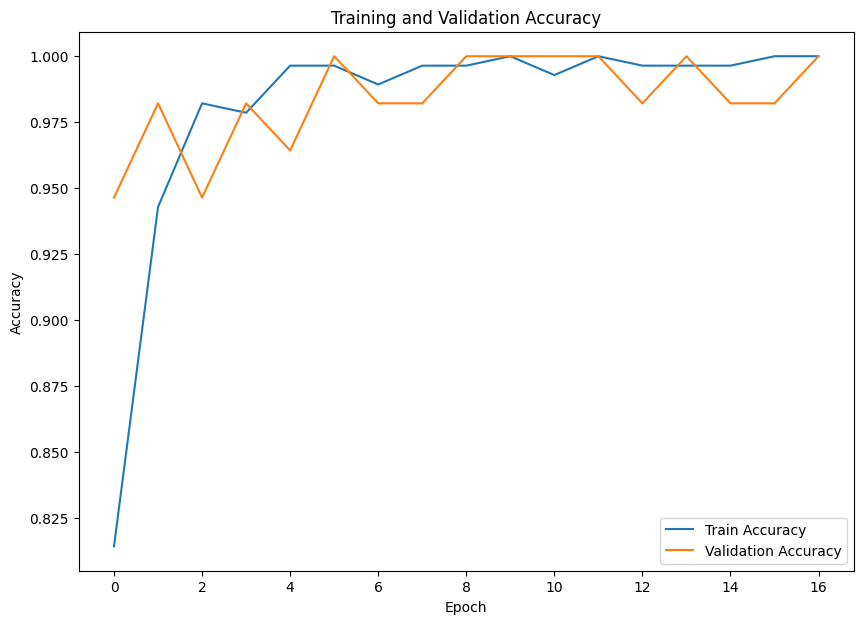

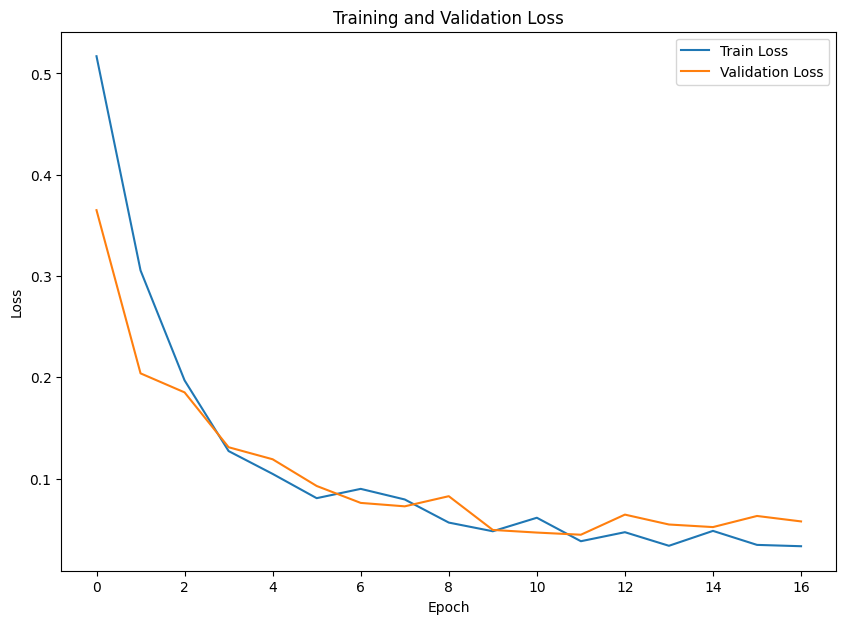

Best val Loss: 0.0445
Best val Acc: 1.0000


In [46]:
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)